# **Basic usage**

In [1]:
import commot as ct
import scanpy as sc
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

**Load spatial transcriptomics dataset.**
e.g., a Visium dataset.

In [2]:
adata = sc.datasets.visium_sge(sample_id='V1_Mouse_Brain_Sagittal_Posterior')
adata.var_names_make_unique()

**Basic preprocessing** \
The method assumes non-negative values that reflect the abundancy of signaling molecules.

In [3]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

**Specify ligand-receptor pairs** \
Here, we use an example with only three LR pairs. \
A user-defined LR database can be specified in the same way or alternatively, built-in LR databases can be obtained with the function `commot.pp.ligand_receptor_database()`. \
For example `df_ligrec=ct.pp.ligand_receptor_database(database='CellChat', species='mouse')`.

In [4]:
LR=np.array([['Tgfb1', 'Tgfbr1_Tgfbr2', 'Tgfb_pathway'],
    ['Tgfb2', 'Tgfbr1_Tgfbr2', 'Tgfb_pathway'],
    ['Tgfb3', 'Tgfbr1_Tgfbr2', 'Tgfb_pathway'],
    ['Fgf1', 'Fgfr1', 'FGF_pathway'],
    ['Fgf1', 'Fgfr2', 'FGF_pathway']],dtype=str)
df_ligrec = pd.DataFrame(data=LR)

**Construct CCC networks** \
Use optimal transport to construct CCC networks for the ligand-receptor pairs with a spatial distance constraint of 500 $\mu$m (coupling between cells with distance greater than 500 is prohibited). \
For example, the spot-by-spot matrix for the pair Tgfb1 (ligand) and Tgfbr1_Tgfbr2 (receptor)is stored in `adata.obsp['commot-user_database-Tgfb1-Tgfbr1_Tgfbr2']`. The total sent or received signal for each pair is stored in `adata.obsm['commot-user_database-sum-sender']` and `adata.obsm['commot-user_database-sum-receiver']`.

In [5]:
ct.tl.spatial_communication(adata,
    database_name='user_database', df_ligrec=df_ligrec, dis_thr=500, heteromeric=True, pathway_sum=True)

**Visualize signaling level** \
Plot the amount of sent and received signal, for example, of the LR pair Fgf1-Fgfr1.

Text(0.5, 1.0, 'Receiver')

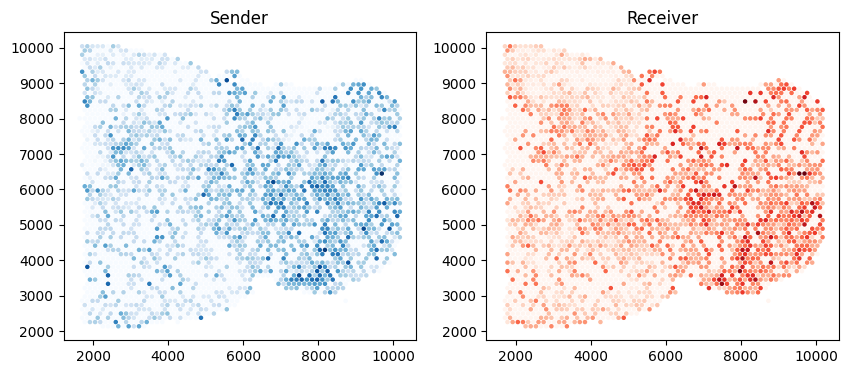

In [6]:
pts = adata.obsm['spatial']
s = adata.obsm['commot-user_database-sum-sender']['s-Fgf1-Fgfr1']
r = adata.obsm['commot-user_database-sum-receiver']['r-Fgf1-Fgfr1']
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].scatter(pts[:,0], pts[:,1], c=s, s=5, cmap='Blues')
ax[0].set_title('Sender')
ax[1].scatter(pts[:,0], pts[:,1], c=r, s=5, cmap='Reds')
ax[1].set_title('Receiver')

**Visualize signaling directions** \
Interpolate the signaling directions as vector fields.

<AxesSubplot: >

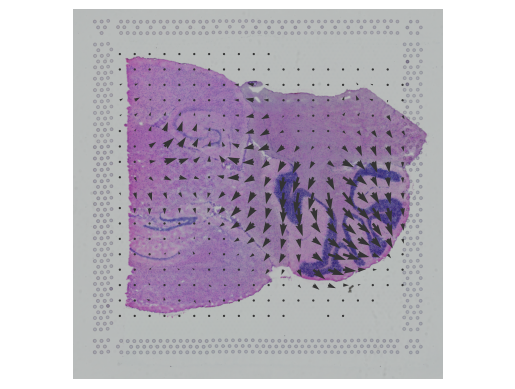

In [7]:
ct.tl.communication_direction(adata, database_name='user_database', lr_pair=('Fgf1','Fgfr1'), k=5)
ct.pl.plot_cell_communication(adata, database_name='user_database', lr_pair=('Fgf1','Fgfr1'), plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.4, summary='sender', background='image', clustering='leiden', cmap='Alphabet',
    normalize_v = True, normalize_v_quantile=0.995)

Or plot the directions with the level of received signal.

<AxesSubplot: >

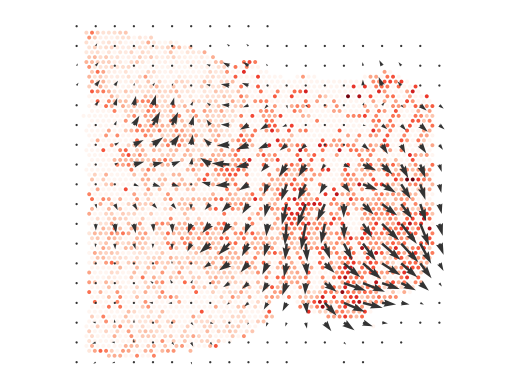

In [8]:
ct.pl.plot_cell_communication(adata, database_name='user_database', lr_pair=('Fgf1','Fgfr1'), plot_method='grid', background_legend=True,
    scale=0.00003, ndsize=8, grid_density=0.4, summary='receiver', background='summary', clustering='leiden', cmap='Reds',
    normalize_v = True, normalize_v_quantile=0.995)

**COMMOT data** \
The results of COMMOT analysis are attached to the anndata object:
- `adata.uns['commot-user_database-info']`: the ligand-receptor database used
- `adata.obsm['commot-user_database-sum-sender']`: the inferred amount of sent signaling through each ligand-receptor pair and the summation over each signaling pathway
- `adata.obsm['commot-user_database-sum-receiver']`: the inferred amount of received signaling through each ligand-receptor pair and the summation over each signaling pathway
- `adata.obsm['commot_sender_vf-user_database-Fgf1-Fgfr1']`: the interpolated signaling direction on each spot with respect to sent signal
- `adata.obsm['commot_receiver_vf-user_database-Fgf1-Fgfr1']`: the interpolated signaling direction on each spot with respect to received signal
- `adata.obsp['commot-user_database-Fgf1-Fgfr1']`: a sparse matrix where the $(i,j)$th element is the CCC score through Fgf1-Fgfr1 from spot $i$ to spot $j$

In [9]:
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial', 'log1p', 'commot-user_database-info'
    obsm: 'spatial', 'commot-user_database-sum-sender', 'commot-user_database-sum-receiver', 'commot_sender_vf-user_database-Fgf1-Fgfr1', 'commot_receiver_vf-user_database-Fgf1-Fgfr1'
    obsp: 'commot-user_database-Fgf1-Fgfr2', 'commot-user_database-Fgf1-Fgfr1', 'commot-user_database-Tgfb2-Tgfbr1_Tgfbr2', 'commot-user_database-Tgfb3-Tgfbr1_Tgfbr2', 'commot-user_database-Tgfb1-Tgfbr1_Tgfbr2', 'commot-user_database-FGF_pathway', 'commot-user_database-Tgfb_pathway', 'commot-user_database-total-total'